# **Import Libraries**

In [ ]:
import pandas as pd
import numpy as np
import re
import string
import nltk
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.utils import resample

nltk.download('stopwords')


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

# **Load Dataset**

In [ ]:
df = pd.read_csv('/content/spam mail.csv', encoding='latin-1')[['Category', 'Masseges']]
df.columns = ['label', 'message']
df['label'] = df['label'].map({'ham': 0, 'spam': 1})

# **Stopword Removal**

In [ ]:
ps = PorterStemmer()
stop_words = set(stopwords.words('english'))

def preprocess(text):
    text = text.lower()
    text = re.sub(r'[^a-zA-Z]', ' ', text)
    words = text.split()
    words = [ps.stem(word) for word in words if word not in stop_words]
    return " ".join(words)

df['message'] = df['message'].apply(preprocess)


In [ ]:
ham = df[df.label == 0]
spam = df[df.label == 1]

spam_upsampled = resample(spam,
                          replace=True,
                          n_samples=len(ham),
                          random_state=42)

df_balanced = pd.concat([ham, spam_upsampled])
df_balanced = df_balanced.sample(frac=1, random_state=42)


# **Model Training**

In [ ]:
tfidf = TfidfVectorizer(ngram_range=(1, 2), stop_words='english')
X = tfidf.fit_transform(df_balanced['message'])
y = df_balanced['label']


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [ ]:
model = LogisticRegression()
model.fit(X_train, y_train)


LogisticRegression()

In [ ]:
y_pred = model.predict(X_test)
print(" Accuracy:", accuracy_score(y_test, y_pred))
print("\n Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\n Classification Report:\n", classification_report(y_test, y_pred))


 Accuracy: 0.9968911917098445

 Confusion Matrix:
 [[973   2]
 [  4 951]]

 Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00       975
           1       1.00      1.00      1.00       955

    accuracy                           1.00      1930
   macro avg       1.00      1.00      1.00      1930
weighted avg       1.00      1.00      1.00      1930



# **Testing the Model**

In [ ]:
def predict_message(msg):
    msg_clean = preprocess(msg)
    msg_vec = tfidf.transform([msg_clean])
    prediction = model.predict(msg_vec)[0]
    return 'Spam' if prediction == 1 else 'Ham'

test_messages = [
    "URGENT! You have won a lottery worth 2 crores. Call this number now!",
    "Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005.",
    "Hey, are we still meeting for lunch today?",
    "Your Netflix account has been suspended. Click this link to verify.",
]

for msg in test_messages:
    print(f" Message: {msg}")
    print(f" Prediction: {predict_message(msg)}\n")


 Message: URGENT! You have won a lottery worth 2 crores. Call this number now!
 Prediction: Spam

 Message: Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005.
 Prediction: Spam

 Message: Hey, are we still meeting for lunch today?
 Prediction: Ham

 Message: Your Netflix account has been suspended. Click this link to verify.
 Prediction: Ham



In [ ]:
df_balanced['predicted'] = model.predict(tfidf.transform(df_balanced['message']))

# False negatives = Actual spam predicted as ham
false_negatives = df_balanced[(df_balanced['label'] == 1) & (df_balanced['predicted'] == 0)]

print("🔍 False Negatives (Spam classified as Ham):\n")
print(false_negatives['message'].head())


🔍 False Negatives (Spam classified as Ham):

868     hello need posh bird chap user trial prod cham...
4966    donat unicef asian tsunami disast support fund...
868     hello need posh bird chap user trial prod cham...
3458    heard u call night knicker make beg like u las...
3740                                                 tf p
Name: message, dtype: object


# **Saving Model**

In [ ]:
joblib.dump(pipeline, 'spam_classifier_pipeline.pkl')

['spam_classifier_pipeline.pkl']

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
import joblib

# Load the dataset
df = pd.read_csv("/content/spam mail.csv", encoding='latin-1')
# Fix: Use the correct column names 'Category' and 'Masseges'
df = df[['Category', 'Masseges']]
df.columns = ['label', 'message']

# Map labels to binary values
df['label'] = df['label'].map({'ham': 0, 'spam': 1})

# Split data
X_train, X_test, y_train, y_test = train_test_split(df['message'], df['label'], test_size=0.2, random_state=42)

# Build pipeline
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('clf', MultinomialNB())
])

# Train model
pipeline.fit(X_train, y_train)

# Save pipeline
joblib.dump(pipeline, 'spam_classifier_pipeline.pkl')

print("Model trained and saved as spam_classifier_pipeline.pkl")

Model trained and saved as spam_classifier_pipeline.pkl


# **Summary of data**

/tmp/ipython-input-4008282768.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='label', data=df, palette='Set2')


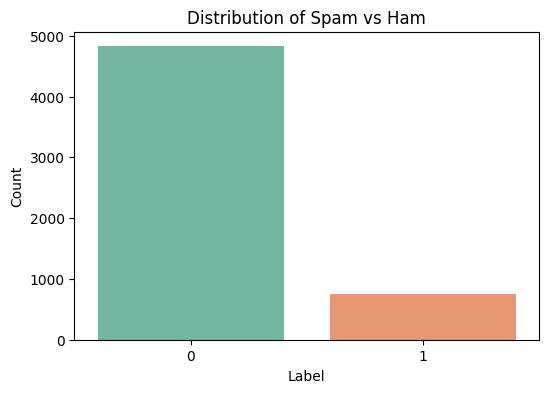

In [60]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

# Load dataset
df = pd.read_csv("/content/spam mail.csv", encoding='latin-1')
# Fix: Use the correct column names 'Category' and 'Masseges' for renaming
df = df.rename(columns={"Category": "label", "Masseges": "message"})
df = df[['label', 'message']]

# Map labels to numerical values
df['label'] = df['label'].map({'ham': 0, 'spam': 1})

# Visual 1: Count of Spam vs Ham
plt.figure(figsize=(6,4))
sns.countplot(x='label', data=df, palette='Set2')
plt.title('Distribution of Spam vs Ham')
plt.xlabel('Label')
plt.ylabel('Count')
plt.show()
